In [1]:
from pragmaticquant import market, model, pricing, payoffs

mkt_datas = market.MarketDatas.load_json('mkt.json')
mkt = market.Market(mkt_datas)
print('Market RefDate = %s' % mkt.refdate())

hw_model = model.hw1Fmodel('USD', 0.0, {'5y' : '5y'})
config = pricing.PricingConfig(algorithm = pricing.MonteCarloAlgo(50000),
                               model = hw_model, 
                               market = mkt_datas)

Market RefDate = 2015-04-29 00:00:00


In [2]:
from dateutil.relativedelta import relativedelta
from pragmaticquant.schedule import swap_schedule, day_count
from pragmaticquant.payoffs.observable import rate_libor

start = mkt_datas.refdate + relativedelta(days = 3)
end = start +  relativedelta(years = 20)
strike = mkt.forward_swaprate('USD', start, end) + 0.01

swap = payoffs.Product('Swap')
for cpn in swap_schedule(start, end, '1y'):
    dcf = day_count(cpn.start, cpn.end, '30/360')
    swap.add_dslcoupon(cpn.pay, 'USD',
                       id='FixedCoupon',
                       script = '-Dcf  * Strike',
                       Dcf = dcf,
                       Strike = strike)
    swap.add_callability_option(cpn.pay, callfee = 0.0, notice = '7d')

for cpn in swap_schedule(start, end, '3m'):
    dcf = day_count(cpn.start, cpn.end, 'act/360')
    swap.add_dslcoupon(cpn.pay, 'USD',
                       id='FloatCoupon',
                       script = 'Dcf  * Libor@FixingDate',
                       Dcf = dcf,
                       Libor = rate_libor('USD', '3m'),
                       FixingDate = cpn.fixing)

priceable = pricing.PriceableConfig(product=swap, pricing_config=config)
%time price, cur, details = pricing.compute_price(priceable)

print('%r %r'%(price * 100.0, cur))

Wall time: 4.52 s
0.07521114773769873 'USD'


In [4]:
from numpy import linspace
from pragmaticquant import risks, scenarios

task = pricing.get_risk_profile_task([risks.rate_vega('USD')], scenarios.rate('USD'), 
                                     linspace(-0.02, 0.03, 11))
%time result = task(priceable)

Pricing Done for shock= -0.02
Pricing Done for shock= -0.015
Pricing Done for shock= -0.01
Pricing Done for shock= -0.005000000000000001
Pricing Done for shock= 0.0
Pricing Done for shock= 0.005000000000000001
Pricing Done for shock= 0.009999999999999998
Pricing Done for shock= 0.015000000000000003
Pricing Done for shock= 0.02
Pricing Done for shock= 0.024999999999999998
Pricing Done for shock= 0.03
Wall time: 2min 18s


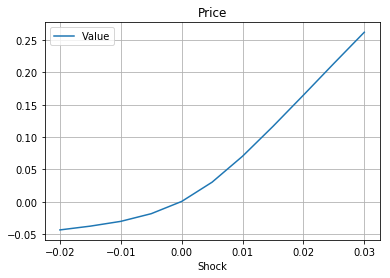

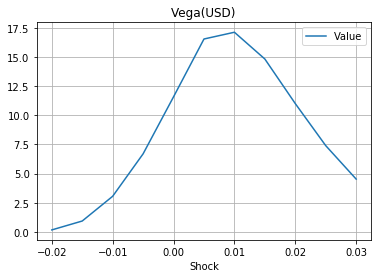

In [5]:
%matplotlib inline
for g, df in result.groupby('Risk'):
    df = df.sort_values(by='Shock', inplace = False)
    df.plot(y='Value', x='Shock', grid=True, title='%s'%g)